## scikit-allel small-scale example

[`scikit-allel`](http://scikit-allel.readthedocs.org/en/latest/) is a Python library for exploratory analysis of large-scale genome variation data. Please refer to the official scikit-allel blog post for a more comprehensive demo:

http://alimanfoo.github.io/2015/09/15/introducing-scikit-allel.html

In [12]:
import numpy as np
import allel
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import vcfnp
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [1]:
# Downloads necessary data
!wget ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.h5
!wget ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.2L.h5

--2015-11-29 21:32:57--  ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.h5
           => 'ag1000g.phase1.ar3.haplotypes.h5.1'
Resolving ngs.sanger.ac.uk... 193.62.203.121
Connecting to ngs.sanger.ac.uk|193.62.203.121|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /production/ag1000g/phase1/AR3/haplotypes/main/hdf5 ... done.
==> SIZE ag1000g.phase1.ar3.haplotypes.h5 ... 1072
==> PASV ... done.    ==> RETR ag1000g.phase1.ar3.haplotypes.h5 ... done.
Length: 1072 (1.0K) (unauthoritative)

ag1000g.phase1.ar3. 100%[=====================>]   1.05K  --.-KB/s   in 0.001s 

2015-11-29 21:32:57 (700 KB/s) - 'ag1000g.phase1.ar3.haplotypes.h5.1' saved [1072]



I'm going to use data from the [Ag1000G phase 1 AR3 release](http://www.malariagen.net/data/ag1000g-phase1-AR3). I have a copy of the data downloaded to a local drive.

The data are stored in [HDF5 files](https://www.hdfgroup.org/HDF5/). Let's take a look.

In [13]:
callset_fn = 'ag1000g.phase1.ar3.haplotypes.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.h5" (mode r)>

In [14]:
# pick a chromosome to work with
chrom = '2L'

In [15]:
# access variants
variants = callset[chrom]['variants']
variants

<HDF5 group "/2L/variants" (4 members)>

Every genetic variant (in this case they are all SNPs) has a position on the genome. Working with these positions is a very common operation.

In [16]:
pos = allel.SortedIndex(variants['POS'][:])
pos

SortedIndex((8296599,), dtype=int32)
[   44691    44732    44736 ..., 49356426 49356429 49356435]

Let's plot the density of these variants over the chromosome.

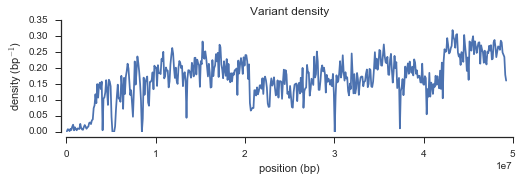

In [17]:
bin_width = 100000
bins = np.arange(0, pos.max(), bin_width)
# set X coordinate as bin midpoints
x = (bins[1:] + bins[:-1])/2
# compute variant density
h, _ = np.histogram(pos, bins=bins)
y = h / bin_width
# plot
fig, ax = plt.subplots(figsize=(8, 2))
sns.despine(ax=ax, offset=5)
ax.plot(x, y)
ax.set_xlabel('position (bp)')
ax.set_ylabel('density (bp$^{-1}$)')
ax.set_title('Variant density');

Let's say I have a gene of interest. I know what position it starts and ends, and I want to find variants within the gene.

In [18]:
start, stop = 2358158, 2431617
loc = pos.locate_range(start, stop)
loc

slice(24470, 26180, None)

I can use this slice to load genotype data for the region of interest.

In [19]:
g = allel.GenotypeArray(callset[chrom]['calldata']['genotype'][loc])
g

,0,1,2,3,4,...,768,769,770,771,772
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


There are various manipulations that can be done on a genotype array, e.g., convert to the number of alternate alleles per call.

In [20]:
gn = g.to_n_alt()
gn

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

From there we could compute genetic distance between each pair of individuals...

In [21]:
dist = allel.stats.pairwise_distance(gn, metric='euclidean')
dist

array([ 12.4498996 ,   1.41421356,   2.        , ...,  25.07987241,
        16.76305461,  21.49418526])

...which we could quickly visualise...

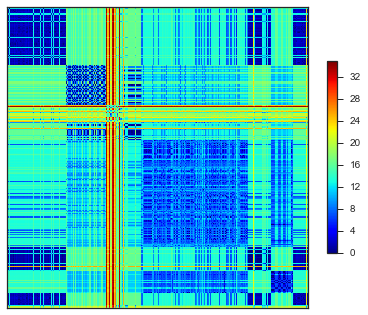

In [22]:
allel.plot.pairwise_distance(dist);

## Further reading

I will leave it there for now, but check out the [scikit-allel docs](http://scikit-allel.readthedocs.org/en/latest/index.html) for more information. There is a section on [data structures](http://scikit-allel.readthedocs.org/en/latest/model.html), which includes both contiguous in-memory and compressed data structures for dealing with very large arrays (made possible thanks to [bcolz](http://bcolz.blosc.org/)). The [statistics](http://scikit-allel.readthedocs.org/en/latest/stats.html) section has various functions for computing diversity, Fst, LD, running PCA, and doing admixture tests. And the [plotting](http://scikit-allel.readthedocs.org/en/latest/plot.html) section has a couple of useful plotting functions.

It is just a beginning, but hopefully a step in a good direction.